# Logistic-regression classifier

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

## Load data
Source: https://www.kaggle.com/uciml/pima-indians-diabetes-database

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. In particular, all observations are related to females at least 21 years old of Pima Indian heritage.

In [3]:
df = pd.read_csv("csv/diabetes.csv") 
df.head(7)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1


In [3]:
# Rename the DiabetesPedigreeFunction column
df.rename(columns={'DiabetesPedigreeFunction': 'PedFunc'},inplace=True)
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'PedFunc', 'Age', 'Outcome'],
      dtype='object')

In [4]:
# Make sure that there are no missing (NaN values)
nancheck = df.isna().any() 
print('No. of NaN values:',len(nancheck[nancheck == True]))

No. of NaN values: 0


The dataset consist of several medical **predictor variables** (independent, the features) and one target (dependent) variable, **Outcome**. 

Predictors are:
   - Pregnancies, number of times pregnant
   - Glucose, plasma glucose concentration a 2 hours in an oral glucose tolerance test
   - BloodPressure, diastolic blood pressure (mm Hg)
   - SkinThickness, triceps skin fold thickness (mm)
   - Insulin, 2 hour serum insulin (mu U/ml)
   - BMI, body mass index ($\text{weight in kg} / (\text{height in $m$})^2$)
   - DiabetesPedigreeFunction, diabetes pedigree function
   - Age, age (years)


In [5]:
outcome_names = ['no diabete','diabete']
diabs = dict( zip( np.sort(df['Outcome'].unique()) , outcome_names ) ) 

print('Outcome legend:')
for key, value in diabs.items():
    print(' - {} means {}' .format(key,value))
#endfor

Outcome legend:
 - 0 means no diabete
 - 1 means diabete


### Plots facilities 

In [6]:
# Function to despine box plots and draw dashed horizontal lines
def despinehlines(ax):
    # despine plot box 
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # draw horizontal axis lines
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, linestyle='--', alpha=0.4, color='#eeeeee')
    #endfor
#endfunction

# Plotting data function
def plotdata(ax,data,target,targnames,colors,markers):
    # number of classes
    nclass = len( np.unique(target) )
    for i in range(nclass):
        xs = data[target == i].iloc[:,0]
        ys = data[target == i].iloc[:,1]
        ax.scatter(xs, ys, c=colors[i], marker=markers[i], s=35)
        #ax.legend(targnames)
    #endfor
#endfunction

# Set of colors, features, and markers
colors   = ['#B0E0E6', '#696969']
features = df.columns
markers  = ['.','x']

# Pairplot function
def pairplot(data,target,features,colors,markers):
    # number of features - 1
    n = len(data.columns[:-1]) - 1
    fig, ax = plt.subplots(n, n, figsize=(20, 18))
    fig.subplots_adjust(left=0.01, right=1, bottom=0, top=1,hspace=0.05, wspace=0.05)
    for i in range(n):
        for j in range(n):        
            if j <= i:
                plotdata(ax[i,j],data.iloc[:,[j,i+1]],target.values,features,colors,markers)        
                if i == n-1: ax[i,j].set_xlabel(df.columns[j],fontsize=18)
                if j == 0:   ax[i,j].set_ylabel(df.columns[i+1],fontsize=18)
                if j > 0:    ax[i,j].set_yticks([])
                if i < n-1:  ax[i,j].set_xticks([])  
            else:
                ax[i,j].set_visible(False)
            #endif
        #endfor
    #endfor
#endfunction

# box plot
def plotbox(fig,ax,data,col,byname):
    data.boxplot(column=col,by=byname,grid=False, ax=ax)
    ax.set_title('{} (grouped by {})'.format(col,byname))
    fig.suptitle("")
    despinehlines(ax)
    ax.axis('tight')
#endfunction

### Histogram of data features

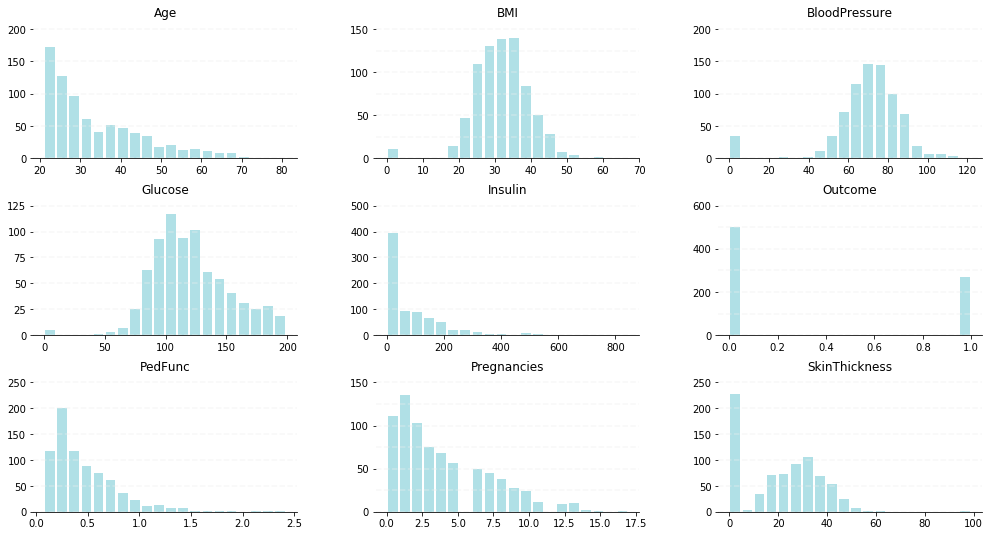

In [7]:
ax = df.hist(bins=20, grid=False, figsize=(17,9), layout=(3,3), color='#B0E0E6', rwidth=0.8) 
ax = ax.flatten()

for n in range(len(ax)):
    despinehlines(ax[n])
#endfor

### Pair plot

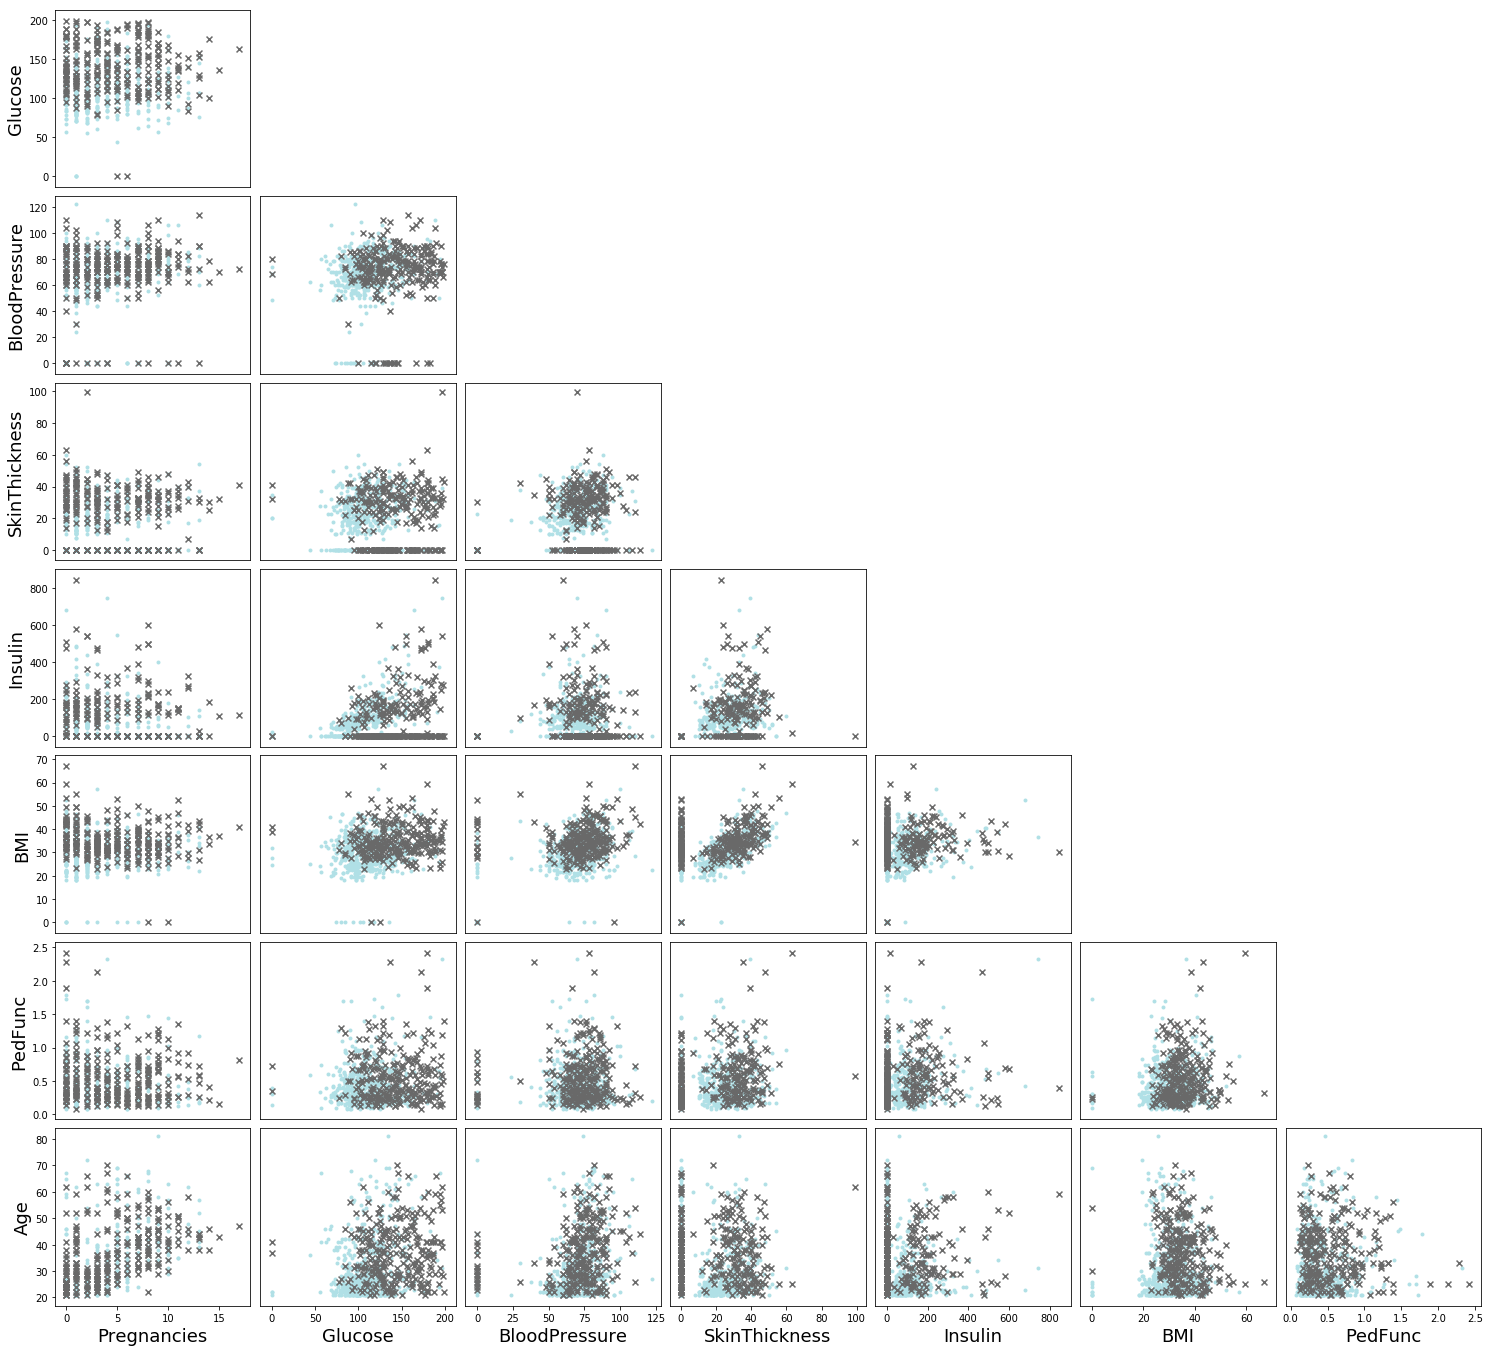

In [8]:
pairplot(df,df['Outcome'],df.columns,colors,markers)

In [9]:
# In alternative, use the scatter_matrix function from pandas 
#scp = pd.plotting.scatter_matrix(df.drop(columns='Outcome'), c=df['Outcome'], figsize=(19, 15), marker='o',hist_kwds={'bins': 20}, s=25, alpha=.8)

### Some data analysis

In [10]:
nobs = len(df.index)
nnodiab = df[ df['Outcome']==0 ].shape[0]
ndiab   = df[ df['Outcome']==1 ].shape[0]
print('Total observations:    ',nobs)
print(' - No. of diabets:     ',ndiab)
print(' - No. of not diabets: ',nnodiab)

Total observations:     768
 - No. of diabets:      268
 - No. of not diabets:  500


#### Age - Diabet relation 
Let us see how age is related with diabet

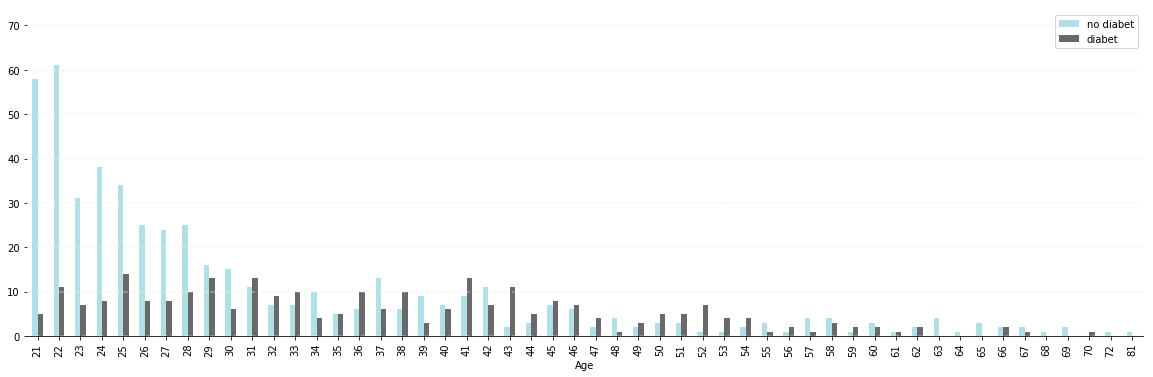

In [11]:
ct = pd.crosstab(df['Age'],df['Outcome'])
ax = ct.plot(figsize=(20,6),kind='bar',color=colors)
ax.legend(['no diabet','diabet'])
despinehlines(ax)

Overall, we see that as age increases, a person is more likely to have diabet (cyan bars decreasing in magnitude). On the other hand, there are much less persons, which are between $55$ and $81$ years old, having a diabet. In fact:

In [12]:
print('Overall number of person with diabet:')
print(' - age range (21,54): ', pd.crosstab(df['Age'],df['Outcome']).iloc[0:34,1].sum() )
print(' - age range (55,81): ', pd.crosstab(df['Age'],df['Outcome']).iloc[34:,1].sum()  )

Overall number of person with diabet:
 - age range (21,54):  250
 - age range (55,81):  18


#### Average of features with respect to diabet

In [13]:
subdf = df.groupby('Outcome').mean()
subdf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedFunc,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


We observe that, on average, Pregnancies, Glucose, Insulin, PedFunc, and Age are the variables with higher impact about having a diabet or not. 

For example, we have just seen the relation about diabet and age. Here, we see that the average age of people without diabet is $31.9$ and while it is $37$ for people having diabet. Also, we see that average level of insuline for people without diabet is about $69$ while this is about $100$ for people having diabet.

Let us compute the *relative* differences for each feature and look at higher ones. For a given feature, 
by *relative* difference, we mean the absolute value of the difference of the two entries divided by the maximum of them.

In [15]:
print('Relative differences:')
for col in subdf.columns:
    diff = abs( subdf[col][0] - subdf[col][1] ) / abs( subdf[col].max() )
    print(' - {}: {:.4f}'.format(col,diff))
#endfor

Relative differences:
 - Pregnancies: 0.3222
 - Glucose: 0.2214
 - BloodPressure: 0.0373
 - SkinThickness: 0.1128
 - Insulin: 0.3144
 - BMI: 0.1377
 - PedFunc: 0.2194
 - Age: 0.1586


Let us consider the following features: Pregnancies, Glucose, Insulin, PedFunc, and Age

In [16]:
subdf = df.drop(columns=["BloodPressure","SkinThickness","BMI"])
subdf.head()

,Pregnancies,Glucose,Insulin,PedFunc,Age,Outcome
0,6,148,0,0.627,50,1
1,1,85,0,0.351,31,0
2,8,183,0,0.672,32,1
3,1,89,94,0.167,21,0
4,0,137,168,2.288,33,1


#### Box plot of current extracted features

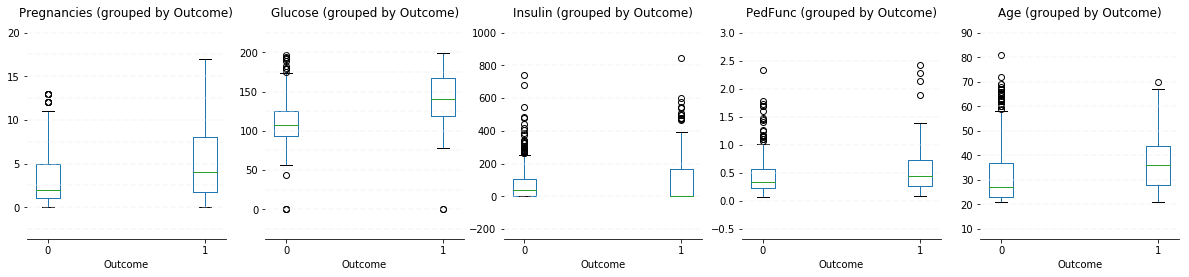

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
ax = ax.flatten()
for n, col in enumerate( subdf.columns[:-1] ): 
    plotbox(fig,ax[n],subdf,col,"Outcome")
#endfor

## Logistic regression
Predicting diabets

In [18]:
# logistic regression instance
lr = LogisticRegression(solver='newton-cg')

In [19]:
def logregpred(clf, X_train, X_test, y_train, y_test):
    # training
    clf.fit(X_train, y_train)
    # validation (prediction of the test set) 
    y_pred = clf.predict(X_test)
    # score
    score = clf.score(X_test, y_test)
    print('Score: {:.2f}%'.format(score*100))
    # confusion matrix
    print('Confusion matrix:')
    print(metrics.confusion_matrix(y_test, y_pred))
#endfunction

We first use the dataframe subdf

In [21]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(subdf.drop(columns="Outcome"),subdf['Outcome'])    

# logistic regression
logregpred(lr, X_train, X_test, y_train, y_test)

Score: 77.08%
Confusion matrix:
[[112  21]
 [ 23  36]]


Now use the dataset with all features

In [22]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Outcome"),df['Outcome'])   

# logistic regression
logregpred(lr, X_train, X_test, y_train, y_test)

Score: 79.69%
Confusion matrix:
[[109  12]
 [ 27  44]]


We see that predictions of diabets using the sub dataframe subdf containg a subset of features are, overall, as accurate as predictions using the entire dataset. 

### Sensitivity to train size  

In [23]:
# Using the entire dataset

# Test sizes
testsize = [0.1, 0.3, 0.5, 0.7, 0.9]

for ts in testsize:
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Outcome"),df['Outcome'],test_size=ts)
    # logistic regression
    lr.fit(X_train,y_train) 
    # prediction of the test set 
    y_pred = lr.predict(X_test)
    # score
    score = lr.score(X_test,y_test)
    # confusion matrix
    print('Train size: {:.1f}'.format(1-ts))
    print('Score:      {:.2f}%'.format(score*100))
    print('Confusion matrix:')
    print(metrics.confusion_matrix(y_test,y_pred))
#endfor

Train size: 0.9
Score:      84.42%
Confusion matrix:
[[51  6]
 [ 6 14]]
Train size: 0.7
Score:      76.19%
Confusion matrix:
[[134  13]
 [ 42  42]]
Train size: 0.5
Score:      78.39%
Confusion matrix:
[[224  25]
 [ 58  77]]
Train size: 0.3
Score:      77.70%
Confusion matrix:
[[313  39]
 [ 81 105]]
Train size: 0.1
Score:      72.25%
Confusion matrix:
[[343 110]
 [ 82 157]]


## Comparison with SVM and kNN

In [24]:
def classifier(X_train, X_test, y_train, y_test,nameclf):
    if nameclf == 'logistic':
        # logistic regression classifier
        clf = LogisticRegression(solver='newton-cg')
    elif nameclf == 'svm':
        # support vector machine classifier
        clf = SVC(C=1, kernel='linear', gamma='auto')
    else:
        # k-nearest neighbours
        clf = KNeighborsClassifier(n_neighbors=5)
    #endif
    clf.fit(X_train,y_train)
    #pred = logreg.predict(X_test)
    score = clf.score(X_test,y_test)
    return score
#endfor

# Using the subdf dataframe

# number of iterations
times = 15

# allocate memory for score matrix
score = np.zeros((times,3))

for n in range(times):
    # test train split
    X_train, X_test, y_train, y_test = train_test_split(subdf.drop(columns="Outcome"),subdf['Outcome'])
    # classifier
    score_logreg = classifier(X_train, X_test, y_train, y_test, 'logistic')
    score_svm    = classifier(X_train, X_test, y_train, y_test, 'svm')
    score_knn    = classifier(X_train, X_test, y_train, y_test, 'knn')
    # collect scores
    score[n,:] = [score_logreg,score_svm,score_knn]
#endfor
#print(score)

meansc = np.mean(score,axis=0)
print('Mean scores classifier:')
print(' * Logistic:',meansc[0])
print(' * SVM:     ',meansc[1])
print(' * kNN:     ',meansc[2])

Mean scores classifier:
 * Logistic: 0.7545138888888889
 * SVM:      0.7541666666666667
 * kNN:      0.7163194444444445


Overall, we see that for this dataset, the kNN (with $5$ neighbours) is less accurate than logistic regression and svm (with default parameters) 